In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


data_path = 'loan_data.csv'
loan_data = pd.read_csv(data_path)
loan_data.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#preprocessing
categorical_cols = loan_data.select_dtypes(include=['object']).columns
numerical_cols = loan_data.select_dtypes(exclude=['object']).columns.drop('not.fully.paid')

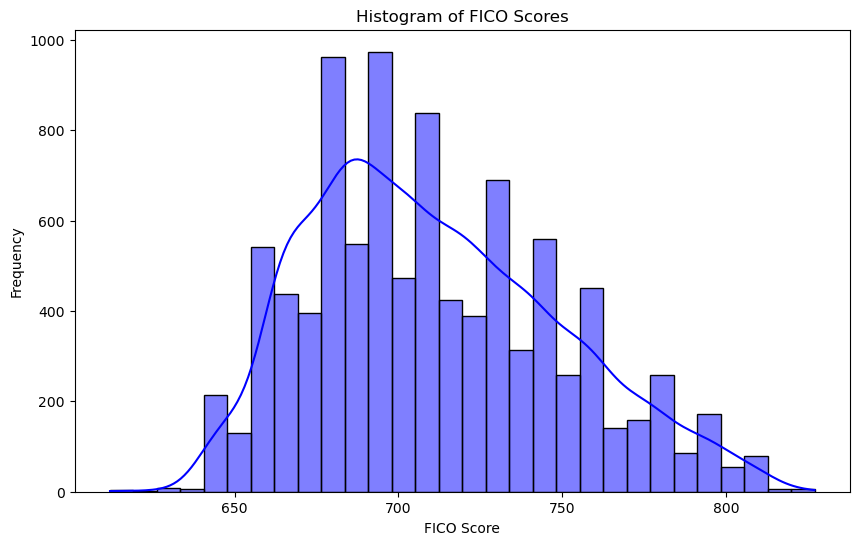

In [33]:
plt.figure(figsize=(10, 6))
sns.histplot(loan_data['fico'], bins=30, kde=True, color='blue')
plt.title('Histogram of FICO Scores')
plt.xlabel('FICO Score')
plt.ylabel('Frequency')
plt.show()

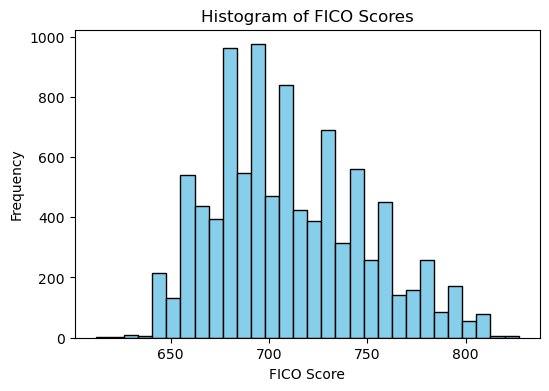

In [41]:
plt.figure(figsize=(6, 4))
plt.hist(loan_data['fico'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of FICO Scores')
plt.xlabel('FICO Score')
plt.ylabel('Frequency')
plt.show()

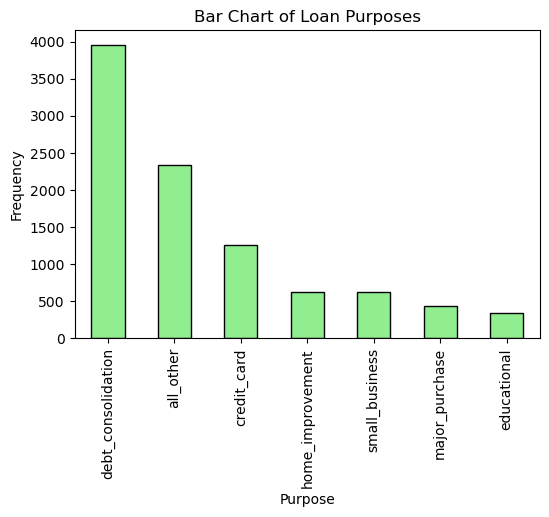

In [43]:
plt.figure(figsize=(6, 4))
loan_data['purpose'].value_counts().plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Bar Chart of Loan Purposes')
plt.xlabel('Purpose')
plt.ylabel('Frequency')
plt.show()

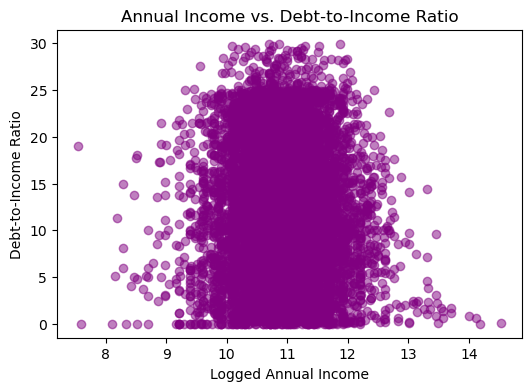

In [45]:
plt.figure(figsize=(6, 4))
plt.scatter(loan_data['log.annual.inc'], loan_data['dti'], alpha=0.5, color='purple')
plt.title('Annual Income vs. Debt-to-Income Ratio')
plt.xlabel('Logged Annual Income')
plt.ylabel('Debt-to-Income Ratio')
plt.show()


In [11]:
model = LogisticRegression(max_iter=1000)
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', model)])

In [15]:
X = loan_data.drop('not.fully.paid', axis=1)
y = loan_data['not.fully.paid']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [17]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['credit.policy', 'int.rate', 'installment', 'log.annual.inc', 'dti',
       'fico', 'days.with.cr.line', 'revol.bal', 'revol.util',
       'inq.last.6mths', 'delinq.2yrs', 'pub.rec'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['purpose'], dtype='object'))])),
                ('classifier', LogisticRegression(max_iter=1000))])

In [19]:
train_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)
print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)


predictions = clf.predict(X_test)
print(classification_report(y_test, predictions))

Training Accuracy: 0.839989558861916
Testing Accuracy: 0.8376826722338204
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      1615
           1       0.25      0.02      0.03       301

    accuracy                           0.84      1916
   macro avg       0.55      0.50      0.47      1916
weighted avg       0.75      0.84      0.77      1916



In [49]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score


numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])


categorical_features = X.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


clf = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=0))])

# Fit the model
clf.fit(X_train, y_train)

# Predict on the test data
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Adjust the decision threshold
threshold = 0.3 
y_pred = (y_pred_proba >= threshold).astype(int)

# Print the classification report
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC Score:", roc_auc)

              precision    recall  f1-score   support

           0       0.88      0.66      0.75      1615
           1       0.22      0.50      0.30       301

    accuracy                           0.63      1916
   macro avg       0.55      0.58      0.53      1916
weighted avg       0.77      0.63      0.68      1916

ROC-AUC Score: 0.6276045791633668
